In [1]:
import spacy
import os
import spacy
import string
from collections import Counter

In [354]:
cwd = os.getcwd()
print(cwd)
datadir = os.path.join(cwd, 'aclImdb')
traindir = os.path.join(datadir,'train')
testdir = os.path.join(datadir,'test')
train_neg_dir = os.path.join(traindir,'neg')
train_pos_dir = os.path.join(traindir,'pos')
test_neg_dir = os.path.join(testdir,'neg')
test_pos_dir = os.path.join(testdir,'pos')
def get_data(ddir):
    l = os.listdir(ddir)
    dataset = []
    target = []
    for i in range(0,len(l)):
        rank = l[i].split('_')[-1]
        rank = rank.replace('.txt','')
        path = os.path.join(ddir,l[i])
        if os.path.isfile(path):
            file = open(path,'rb')
            if 'pos'in path:
#                 target.append(int(rank)-3)
                target.append(1)
            elif 'neg'in path:
                target.append(0)
#                 target.append(int(rank)-1)
            text = file.read().decode('utf-8')
            dataset.append(text)
    return dataset, target
train_x, train_y = get_data(train_neg_dir)
val_x, val_y = train_x[-2500:], train_y[-2500:]
train_x, train_y = train_x[:-2500], train_y[:-2500]
print(Counter(train_y))
train_x_pos, train_y_pos = get_data(train_pos_dir)
val_x_pos, val_y_pos = train_x_pos[-2500:], train_y_pos[-2500:]
train_x_pos, train_y_pos = train_x_pos[:-2500], train_y_pos[:-2500]
print(Counter(train_y_pos))
train_x.extend(train_x_pos)
train_y.extend(train_y_pos)
val_x.extend(val_x_pos)
val_y.extend(val_y_pos)

test_x, test_y = get_data(test_neg_dir)
test_x_pos, test_y_pos = get_data(test_pos_dir)
test_x.extend(test_x_pos)
test_y.extend(test_y_pos)

print ("Train dataset size is {}".format(len(train_x)))
print ("Val dataset size is {}".format(len(val_x)))
print ("Test dataset size is {}".format(len(test_x)))

H:\NYUCDS\NLP\HW1
Counter({0: 10000})
Counter({1: 10000})
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [234]:
Counter(train_y)

Counter({0: 10000, 1: 10000})

In [355]:
# token
import pickle as pkl
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
stop = stopwords.words('english')
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
# from nltk.tokenize import MWETokenizer
Grams = 1

def tokenize(sent, n):
    tokens = tokenizer(sent)
    t_list =  [token.text.lower() for token in tokens if (token.text not in punctuations and token.text.lower() not in stop)]
    return [''.join(t_list[i:i+n]) for i in range(len(t_list) - n + 1)]
# tokenizer = MWETokenizer()

def tokenize_dataset(dataset):
    token_dataset = []
    all_tokens = []
    for sample in dataset:
        cleantext = BeautifulSoup(sample, "lxml").text
        tokens = tokenize(cleantext, Grams)
        token_dataset.append(tokens)
        all_tokens += tokens
    return token_dataset, all_tokens

# # val set tokens
# print ("Tokenizing val data")
# val_data_tokens, _ = tokenize_dataset(val_x)
# pkl.dump(val_data_tokens, open("val_data_tokens_stop_1.p", "wb"))

# # test set tokens
# print ("Tokenizing test data")
# test_data_tokens, _ = tokenize_dataset(test_x)
# pkl.dump(test_data_tokens, open("test_data_tokens_stop_1.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# train_data_tokens, all_train_tokens = tokenize_dataset(train_x)
# pkl.dump(train_data_tokens, open("train_data_tokens_stop_1.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens_stop_1.p", "wb"))

In [361]:
train_data_tokens = pkl.load(open("train_data_tokens_clean_1.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_clean_1.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_clean_1.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_clean_1.p", "rb"))

print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4753736


In [362]:
from collections import Counter

max_vocab_size = 5000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [363]:
MAX_SENTENCE_LENGTH = 1000

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):

    def __init__(self, data_list, target_list):
  
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):

    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 64
train_dataset = NewsGroupDataset(train_data_indices, train_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_y)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_y)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

In [364]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):

    def __init__(self, vocab_size, emb_dim):
   
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.tan = nn.Tanh()
#         self.relu = nn.ReLU()
        self.linear = nn.Linear(emb_dim,2)
        
    
    def forward(self, data, length):

        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        
        # return logits
        out = self.tan(out.float())
#         out = self.relu(out.float())
        out = self.linear(out.float())
        
        return out

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [281]:
acc_optim = {}
loss_optim = {}

In [365]:
learning_rate = 0.001
num_epochs = 10 # number epoch to train
ngram = 1
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# lambda1 = lambda epoch: num_epochs - epoch
# # lambda2 = lambda epoch: 0.95 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])


# Function for testing the model
def test_model(loader, model):
 
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        data_batch = data_batch.long()
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)
# loss_adam = []
# loss_emb[emb_dim] = []
# loss_vocab[max_vocab_size] = []
# loss_sgd = []
# loss_list[learning_rate] = []
# acc_lr[learning_rate] = []
# loss_lr[learning_rate] = []
# acc_gram[ngram] = []
# loss_gram[ngram] = []
# acc_batch[64] = []
# loss_batch[64] = []
# acc_optim['SGD1'] = []
# loss_optim['SGD1'] = []

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        data_batch = data_batch.long()
        label_batch = label_batch.long()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
#         loss_optim['SGD1'].append(loss)
#         loss_vocab[max_vocab_size].append(loss)
#         loss_list[learning_rate].append(loss)
#         loss_lr[learning_rate].append(loss)
#         loss_gram[ngram].append(loss)
#         loss_batch[64].append(loss)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
#     acc_batch[64].append(val_acc)
#     acc_gram[ngram].append(val_acc)
#     acc_optim['SGD1'].append(val_acc)
#     scheduler.step()
#     print(scheduler.get_lr())


Epoch: [1/10], Step: [101/313], Validation Acc: 64.42
Epoch: [1/10], Step: [201/313], Validation Acc: 71.68
Epoch: [1/10], Step: [301/313], Validation Acc: 75.18
Epoch: [2/10], Step: [101/313], Validation Acc: 80.12
Epoch: [2/10], Step: [201/313], Validation Acc: 82.02
Epoch: [2/10], Step: [301/313], Validation Acc: 83.94
Epoch: [3/10], Step: [101/313], Validation Acc: 84.56
Epoch: [3/10], Step: [201/313], Validation Acc: 85.32
Epoch: [3/10], Step: [301/313], Validation Acc: 86.08
Epoch: [4/10], Step: [101/313], Validation Acc: 86.42
Epoch: [4/10], Step: [201/313], Validation Acc: 87.16
Epoch: [4/10], Step: [301/313], Validation Acc: 86.26
Epoch: [5/10], Step: [101/313], Validation Acc: 87.4
Epoch: [5/10], Step: [201/313], Validation Acc: 87.38
Epoch: [5/10], Step: [301/313], Validation Acc: 87.42
Epoch: [6/10], Step: [101/313], Validation Acc: 87.42
Epoch: [6/10], Step: [201/313], Validation Acc: 87.38
Epoch: [6/10], Step: [301/313], Validation Acc: 87.66
Epoch: [7/10], Step: [101/313

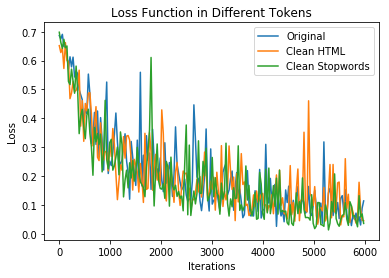

In [42]:
import matplotlib.pyplot as plt
tens = np.arange(0,6000,30)
loss_fun = np.array(loss_token['original'])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_token['clean1'])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_token['stopwords1'])[tens]
plt.plot(tens,loss_fun)
plt.title('Loss Function in Different Tokens')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(('Original','Clean HTML','Clean Stopwords'),loc = 'upper right')
plt.show()

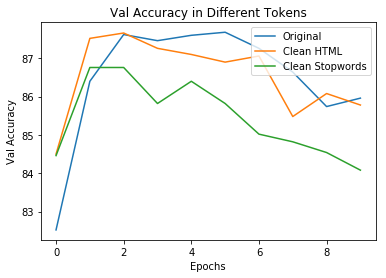

In [43]:
plt.plot(acc_token['original'])
plt.plot(acc_token['clean1'])
plt.plot(acc_token['stopwords1'])

plt.title('Val Accuracy in Different Tokens')
plt.ylabel('Val Accuracy')
plt.xlabel('Epochs')
plt.legend(('Original','Clean HTML','Clean Stopwords'),loc = 'upper right')
plt.show()

In [61]:

acc_vocab[10000] = acc_token['clean1']
loss_vocab[10000] = loss_token['clean1']

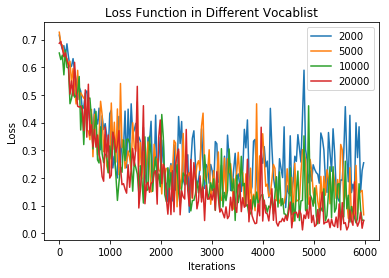

In [85]:
tens = np.arange(0,6000,30)
loss_fun = np.array(loss_vocab[2000])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_vocab[5000])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_vocab[10000])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_vocab[20000])[tens]
plt.plot(tens,loss_fun)
plt.title('Loss Function in Different Vocablist')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(('2000','5000','10000','20000'),loc = 'upper right')
plt.show()

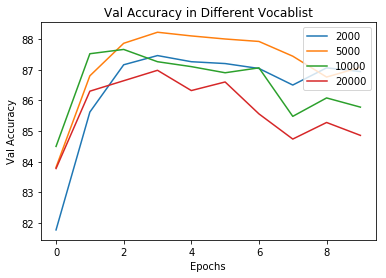

In [86]:
plt.plot(acc_vocab[2000])
plt.plot(acc_vocab[5000])
plt.plot(acc_vocab[10000])
plt.plot(acc_vocab[20000])
plt.title('Val Accuracy in Different Vocablist')
plt.ylabel('Val Accuracy')
plt.xlabel('Epochs')
plt.legend(('2000','5000','10000','20000'),loc = 'upper right')
plt.show()

In [92]:
acc_emb[250] = acc_vocab[5000]
loss_emb[250] = loss_vocab[5000]

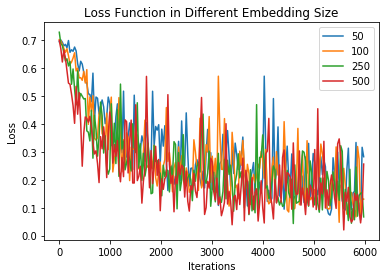

In [119]:
tens = np.arange(0,6000,30)
loss_fun = np.array(loss_emb[50])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_emb[100])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_emb[250])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_emb[500])[tens]
plt.plot(tens,loss_fun)
plt.title('Loss Function in Different Embedding Size')
plt.ylabel('Loss')

plt.xlabel('Iterations')
plt.legend(('50','100','250','500'),loc = 'upper right')
plt.show()

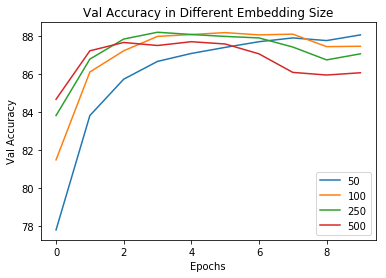

In [121]:
plt.plot(acc_emb[50])
plt.plot(acc_emb[100])
plt.plot(acc_emb[250])
plt.plot(acc_emb[500])
plt.title('Val Accuracy in Different Embedding Size')
plt.ylabel('Val Accuracy')
plt.xlabel('Epochs')
plt.legend(('50','100','250','500'),loc = 'lower right')
plt.show()

In [106]:
import matplotlib.pyplot as plt
# tens = np.arange(0,6000,30)
# loss_fun = np.array(loss_lr[0.001])[tens]
# plt.plot(tens,loss_fun)
# loss_fun = np.array(loss_gram[2])[tens]
# plt.plot(tens,loss_fun)
# loss_fun = np.array(loss_gram[3])[tens]
# plt.plot(tens,loss_fun)
# loss_fun = np.array(loss_gram[4])[tens]
# plt.plot(tens,loss_fun)
# plt.title('Loss Function in N-Grams')
# plt.ylabel('Loss')
# plt.xlabel('Iterations')
# plt.legend(('1-gram','2-gram','3-gram','4-gram'),loc = 'upper right')
# plt.show()

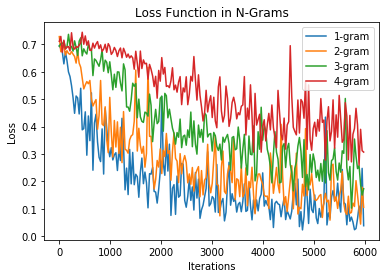

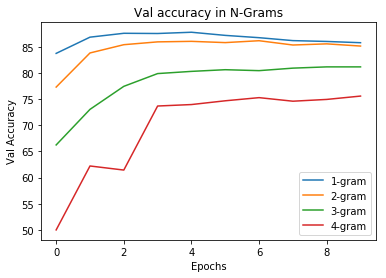

In [170]:
plt.plot(acc_lr[0.001])
plt.plot(acc_gram[2])
plt.plot(acc_gram[3])
plt.plot(acc_gram[4])
plt.title('Val accuracy in N-Grams')
plt.ylabel('Val Accuracy')
plt.xlabel('Epochs')
plt.legend(('1-gram','2-gram','3-gram','4-gram'),loc = 'lower right')
plt.show()

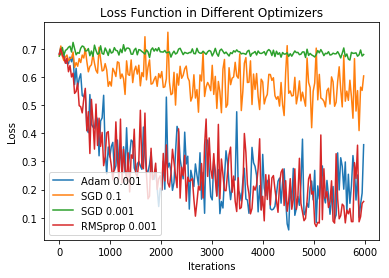

In [352]:
tens = np.arange(0,6000,30)
loss_fun = np.array(loss_optim['Adam'])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_optim['SGD'])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_optim['SGD1'])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_optim['RMSprop'])[tens]
plt.plot(tens,loss_fun)
plt.legend(('Adam 0.001','SGD 0.1','SGD 0.001','RMSprop 0.001'),loc = 'lower left')
plt.title('Loss Function in Different Optimizers')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

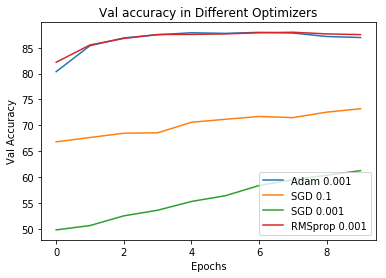

In [353]:
plt.plot(acc_optim['Adam'])
plt.plot(acc_optim['SGD'])
plt.plot(acc_optim['SGD1'])
plt.plot(acc_optim['RMSprop'])

plt.title('Val accuracy in Different Optimizers')
plt.ylabel('Val Accuracy')
plt.xlabel('Epochs')
plt.legend(('Adam 0.001','SGD 0.1','SGD 0.001','RMSprop 0.001'),loc = 'lower right')
plt.show()

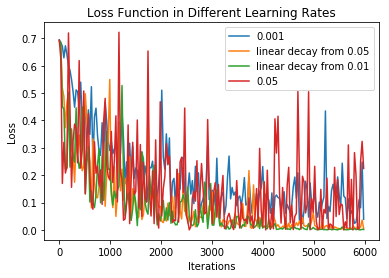

In [104]:
tens = np.arange(0,6000,30)
# loss_fun = np.array(loss_lr[0.5])[tens]
# plt.plot(tens,loss_fun)
loss_fun = np.array(loss_lr[0.001])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_lr['linear'])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_lr['linear1'])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_lr[0.05])[tens]
plt.plot(tens,loss_fun)

plt.legend(('0.001','linear decay from 0.05','linear decay from 0.01','0.05',),loc = 'upper right')
plt.title('Loss Function in Different Learning Rates')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

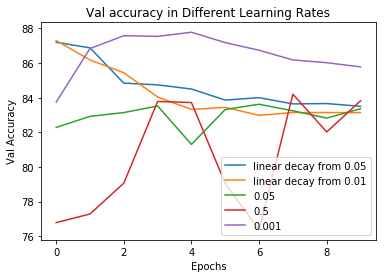

In [107]:
plt.plot(acc_lr['linear'])
plt.plot(acc_lr['linear1'])
plt.title('Val accuracy in Different Learning Rates')
plt.ylabel('Val Accuracy')
plt.xlabel('Epochs')
plt.plot(acc_lr[0.05])
plt.plot(acc_lr[0.5])
plt.plot(acc_lr[0.001])
plt.legend(('linear decay from 0.05','linear decay from 0.01','0.05', '0.5','0.001'),loc = 'lower right')
plt.show()

In [132]:
acc_batch[32] = acc_emb[100]
loss_batch[32] = loss_emb[100]

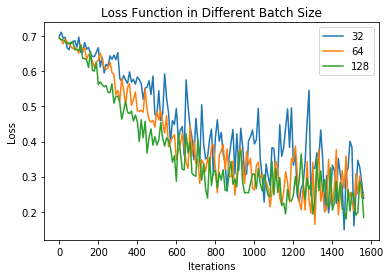

In [147]:
tens = np.arange(0,len(loss_batch[128]),10)
loss_fun = np.array(loss_batch[32])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_batch[64])[tens]
plt.plot(tens,loss_fun)
loss_fun = np.array(loss_batch[128])[tens]
plt.plot(tens,loss_fun)
plt.title('Loss Function in Different Batch Size')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(('32','64','128'),loc = 'upper right')
plt.show()

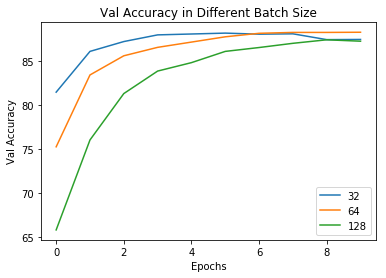

In [151]:
plt.plot(acc_batch[32])
plt.plot(acc_batch[64])
plt.plot(acc_batch[128])
plt.title('Val Accuracy in Different Batch Size')
plt.ylabel('Val Accuracy')
plt.xlabel('Epochs')
plt.legend(('32','64','128'),loc = 'lower right')
plt.show()

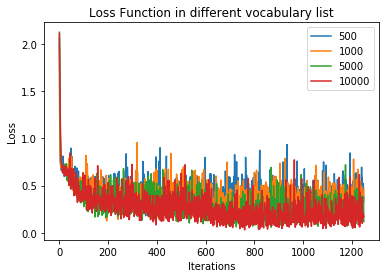

In [297]:
plt.plot(loss_vocab[500])
plt.plot(loss_vocab[1000])
plt.plot(loss_vocab[5000])
plt.plot(loss_vocab[10000])
plt.legend(('500','1000','5000','10000'),loc='upper right')
plt.title('Loss Function in different vocabulary list')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

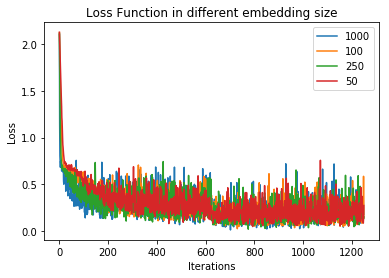

In [230]:
plt.plot(loss_emb[1000])
plt.title('Loss Function in different embedding size')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.plot(loss_emb[100])
plt.plot(loss_emb[250])
plt.plot(loss_emb[50])
plt.legend(('1000','100','250','50'),loc='upper right')
plt.show()

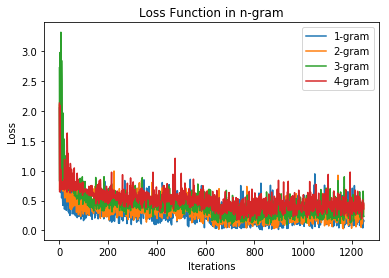

In [182]:
plt.plot(loss_list[1])
plt.plot(loss_list[2])
plt.plot(loss_list[3])
plt.plot(loss_list[4])
plt.legend(('1-gram','2-gram','3-gram','4-gram'),loc='upper right')
plt.title('Loss Function in n-gram')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()


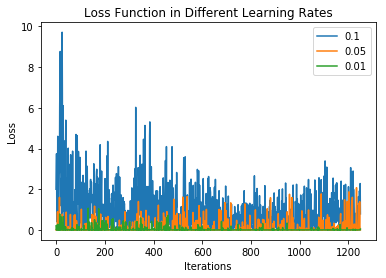

In [311]:
plt.title('Loss Function in Different Learning Rates')
plt.ylabel('Loss')
plt.xlabel('Iterations')

plt.plot(loss_list[0.1])
plt.plot(loss_list[0.05])
plt.plot(loss_list[0.01])
plt.legend(('0.1','0.05','0.01'),loc='upper right')
plt.show()

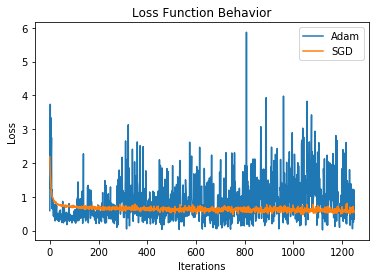

In [95]:
plt.plot(loss_adam)
plt.plot(loss_sgd)
plt.legend(('Adam','SGD'),loc='upper right')
plt.title('Loss Function Behavior')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [366]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 10 epochs
Val Acc 88.22
Test Acc 87.968


In [241]:
def pred(loader, model):
    model.eval()
    result  = []
    y = []
    texts = []
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        data_batch = data_batch.long()
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1].tolist()
        result.extend(predicted)
        y.extend(label_batch.tolist())
        texts.extend(data_batch.tolist())
    return result, y, texts
y_pred, y_flag, texts  = pred(val_loader, model)

In [242]:
for i in range(len(y_pred)):
    if y_pred[i][0] != y_flag[i]:
        print(str(i) +': pred-'+ str(y_pred[i][0]) + ', label-'+ str(y_flag[i]))

8: pred-1, label-0
9: pred-1, label-0
15: pred-1, label-0
17: pred-1, label-0
23: pred-1, label-0
34: pred-0, label-1
38: pred-1, label-0
106: pred-1, label-0
108: pred-0, label-1
116: pred-1, label-0
118: pred-0, label-1
164: pred-1, label-0
174: pred-1, label-0
196: pred-0, label-1
199: pred-0, label-1
208: pred-0, label-1
210: pred-0, label-1
216: pred-1, label-0
221: pred-1, label-0
235: pred-1, label-0
239: pred-1, label-0
242: pred-1, label-0
256: pred-1, label-0
258: pred-1, label-0
265: pred-1, label-0
271: pred-1, label-0
277: pred-1, label-0
278: pred-1, label-0
281: pred-1, label-0
301: pred-0, label-1
305: pred-0, label-1
311: pred-1, label-0
314: pred-0, label-1
331: pred-0, label-1
337: pred-0, label-1
348: pred-1, label-0
351: pred-1, label-0
353: pred-0, label-1
362: pred-0, label-1
375: pred-1, label-0
386: pred-0, label-1
401: pred-1, label-0
414: pred-1, label-0
438: pred-0, label-1
439: pred-0, label-1
460: pred-0, label-1
465: pred-0, label-1
470: pred-1, label-0
4

3213: pred-0, label-1
3215: pred-1, label-0
3221: pred-1, label-0
3243: pred-0, label-1
3257: pred-0, label-1
3261: pred-1, label-0
3266: pred-0, label-1
3278: pred-0, label-1
3299: pred-1, label-0
3319: pred-1, label-0
3324: pred-0, label-1
3325: pred-1, label-0
3329: pred-0, label-1
3349: pred-0, label-1
3352: pred-1, label-0
3355: pred-1, label-0
3380: pred-1, label-0
3381: pred-0, label-1
3402: pred-0, label-1
3410: pred-1, label-0
3425: pred-1, label-0
3427: pred-1, label-0
3447: pred-0, label-1
3457: pred-1, label-0
3458: pred-0, label-1
3460: pred-1, label-0
3473: pred-1, label-0
3482: pred-0, label-1
3524: pred-0, label-1
3535: pred-0, label-1
3566: pred-1, label-0
3571: pred-0, label-1
3573: pred-1, label-0
3597: pred-0, label-1
3606: pred-1, label-0
3612: pred-0, label-1
3614: pred-0, label-1
3618: pred-1, label-0
3623: pred-1, label-0
3631: pred-1, label-0
3632: pred-1, label-0
3633: pred-1, label-0
3648: pred-1, label-0
3659: pred-1, label-0
3698: pred-1, label-0
3707: pred

In [249]:
def delet_zeros(l):
    while 0 in l:
        l.remove(0)
    return l
s = ''
for u in delet_zeros(texts[0]):
    s += id2token[u] + ' '
print(s)
print()
for x in range(len(val_data_tokens)):
    if val_data_tokens[x][1] == 'christmas':
        if val_data_tokens[x][4] == 'one':
            print(' '.join(val_data_tokens[x]))

a christmas story is one of many people 's all time most beloved films <unk> was able to take the viewer to a time and a place in such a way that very few films ever have it had a <unk> and <unk> to it that is rare so i <unk> and <unk> its sequel it runs in the family the film was almost released a couple of times only to be pulled at the last minute when it finally came out <unk> was and is i guess a total failure the sets and cinematography were just fine but the directing totally completely missed the mark the film was nothing more than a cash flow formula of lazy casting lazy writing and <unk> acting the narrator jean <unk> who was one of america 's great <unk> and story <unk> forced upon us a false <unk> of the warm wit he used in <unk> he over <unk> and why he did that i 'll never know he somehow managed to become an annoying <unk> parody of himself the writing and acting in <unk> is <unk> and forced the actors may have seen <unk> but whatever wit and <unk> that was in <unk> must

In [256]:
s = ''
for u in delet_zeros(texts[1]):
    s += id2token[u] + ' '
print(s)
print()
for x in range(len(val_data_tokens)):
    if val_data_tokens[x][1] == 'acting':
        if val_data_tokens[x][7] == 'but':
            print(' '.join(val_data_tokens[x]))

the acting in this movie was superb but mixed with the truth about the condition of many <unk> in south africa made it heart <unk> it was good that the writer isolated <unk> and lena from others run from their <unk> so we could share fully in their <unk> and <unk> the conflicts they <unk> as they grew together and apart worth seeing when you put the movie in it 's proper context 

the acting in this movie was superb but mixed with the truth about the condition of many africans in south africa made it heart wrenching it was good that the writer isolated boesman and lena from others run from their homes so we could share fully in their triumphs and defeats the conflicts they shared as they grew together and apart worth seeing when you put the movie in it 's proper context


In [258]:
s = ''
for u in delet_zeros(texts[2]):
    s += id2token[u] + ' '
print(s)
print()
for x in range(len(val_data_tokens)):
    if val_data_tokens[x][1] == 'adult':
        if val_data_tokens[x][2] == 'realistic':
            print(' '.join(val_data_tokens[x]))

an adult realistic cruel dark story like a second part of <unk> <unk> <unk> the wild <unk> plenty of beauty and sadness <unk> and <unk> shadows and little <unk> of hope a man searching for a warm companion a better life a sincere attitude 

an adult realistic cruel dark story like a second part of les roseaux savages the wild reeds plenty of beauty and sadness ellipsis and silences shadows and little sparks of hope a man searching for a warm companion a better life a sincere attitude


In [263]:
s = ''
for u in delet_zeros(texts[17]):
    s += id2token[u] + ' '
print(s)
print()
for x in range(len(val_data_tokens)):
    if val_data_tokens[x][3] == 'north':
        if val_data_tokens[x][5] == 'florida':
            print(' '.join(val_data_tokens[x]))

this is another north east florida production filmed mainly in and near by to <unk> beach and the <unk> <unk> i was rather surprised the company was able to take over the main street of <unk> beach as long as was necessary to achieve the street scenes the film is pretty and pretty bad <unk> <unk> is cute but <unk> <unk> <unk> <unk> even more good for small kids or for those who like <unk> in large <unk> a 4 from the miller movies formula 

this is another north east florida production filmed mainly in and near by to fernandina beach and the kingsley plantation i was rather surprised the company was able to take over the main street of fernandina beach as long as was necessary to achieve the street scenes the film is pretty and pretty bad tami erin is cute but overacts eileen brennan overacts even more good for small kids or for those who like fluff in large doses a 4 from the miller movies formula


In [269]:
s = ''
for u in delet_zeros(texts[38]):
    s += id2token[u] + ' '
print(s)
print()
for x in range(len(val_data_tokens)):
    if val_data_tokens[x][3] == 'looked':
        if val_data_tokens[x][5] == 'to':
            print(' '.join(val_data_tokens[x]))

i very much looked forward to this movie its a good family movie however if michael <unk> jr. 's editing team did a better job of editing the movie would be much better too many scenes out of context i do hope there is another movie from the series they 're all very good but if another one is made i <unk> them to take better care at editing this story was all over the place and did n't seem to have a center which is unfortunate because the other movies of the series were great i enjoy the story of willie and <unk> they 're both great role models plus the romantic side of the viewers always enjoy a good love story 

i very much looked forward to this movie its a good family movie however if michael landon jr. 's editing team did a better job of editing the movie would be much better too many scenes out of context i do hope there is another movie from the series they 're all very good but if another one is made i beg them to take better care at editing this story was all over the place a

In [274]:
s = ''
for u in delet_zeros(texts[108]):
    s += id2token[u] + ' '
print(s)
print()
for x in range(len(val_data_tokens)):
    if val_data_tokens[x][3] == 'to':
        if val_data_tokens[x][6] == 'ideas':
            print(' '.join(val_data_tokens[x]))

<unk> ho tries to express many ideas and entertain us with a <unk> comedy at the same time the result is uneven but generally entertaining keaton <unk> all three aspects of his lead character quite well <unk> is even better one warning george <unk> is very poor in his supporting role otherwise this is quite enjoyable time <unk> 

gung ho tries to express many ideas and entertain us with a wiseguy comedy at the same time the result is uneven but generally entertaining keaton balances all three aspects of his lead character quite well wantabedde is even better one warning george wendt is very poor in his supporting role otherwise this is quite enjoyable time capsule




Classification on the rating 8 classes

In [186]:
cwd = os.getcwd()
print(cwd)
datadir = os.path.join(cwd, 'aclImdb')
traindir = os.path.join(datadir,'train')
testdir = os.path.join(datadir,'test')
train_neg_dir = os.path.join(traindir,'neg')
train_pos_dir = os.path.join(traindir,'pos')
test_neg_dir = os.path.join(testdir,'neg')
test_pos_dir = os.path.join(testdir,'pos')
def get_data(ddir):
    l = os.listdir(ddir)
    dataset = []
    target = []
    for i in range(0,len(l)):
        rank = l[i].split('_')[-1]
        rank = rank.replace('.txt','')
        path = os.path.join(ddir,l[i])
        if os.path.isfile(path):
            file = open(path,'rb')
            if 'pos'in path:
                target.append(int(rank)-3)
#                 target.append(1)
            elif 'neg'in path:
#                 target.append(0)
                target.append(int(rank)-1)
            text = file.read().decode('utf-8')
            dataset.append(text)
    return dataset, target
train_x, train_y = get_data(train_neg_dir)
val_x, val_y = train_x[-2500:], train_y[-2500:]
train_x, train_y = train_x[:-2500], train_y[:-2500]
print(Counter(train_y))
train_x_pos, train_y_pos = get_data(train_pos_dir)
val_x_pos, val_y_pos = train_x_pos[-2500:], train_y_pos[-2500:]
train_x_pos, train_y_pos = train_x_pos[:-2500], train_y_pos[:-2500]
print(Counter(train_y_pos))
train_x.extend(train_x_pos)
train_y.extend(train_y_pos)
val_x.extend(val_x_pos)
val_y.extend(val_y_pos)

test_x, test_y = get_data(test_neg_dir)
test_x_pos, test_y_pos = get_data(test_pos_dir)
test_x.extend(test_x_pos)
test_y.extend(test_y_pos)

print ("Train dataset size is {}".format(len(train_x)))
print ("Val dataset size is {}".format(len(val_x)))
print ("Test dataset size is {}".format(len(test_x)))

H:\NYUCDS\NLP\HW1
Counter({0: 4077, 3: 2151, 2: 1908, 1: 1864})
Counter({7: 3849, 5: 2394, 4: 1970, 6: 1787})
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [187]:
Counter(train_y)

Counter({0: 4077,
         1: 1864,
         2: 1908,
         3: 2151,
         4: 1970,
         5: 2394,
         6: 1787,
         7: 3849})

In [188]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):

    def __init__(self, vocab_size, emb_dim):

        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.tan = nn.Tanh()
#         self.relu = nn.ReLU()
        self.linear = nn.Linear(emb_dim,8)
        
    
    def forward(self, data, length):
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        
        # return logits
        out = self.tan(out.float())
#         out = self.relu(out.float())
        out = self.linear(out.float())
        
        return out

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [189]:
learning_rate = 0.001
num_epochs = 20 # number epoch to train
ngram = 1
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# lambda1 = lambda epoch: num_epochs - epoch
# # lambda2 = lambda epoch: 0.95 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])


# Function for testing the model
def test_model(loader, model):
 
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        data_batch = data_batch.long()
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        data_batch = data_batch.long()
        label_batch = label_batch.long()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)

        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))


Epoch: [1/20], Step: [101/313], Validation Acc: 24.2
Epoch: [1/20], Step: [201/313], Validation Acc: 26.5
Epoch: [1/20], Step: [301/313], Validation Acc: 28.56
Epoch: [2/20], Step: [101/313], Validation Acc: 30.52
Epoch: [2/20], Step: [201/313], Validation Acc: 31.86
Epoch: [2/20], Step: [301/313], Validation Acc: 33.18
Epoch: [3/20], Step: [101/313], Validation Acc: 34.76
Epoch: [3/20], Step: [201/313], Validation Acc: 35.48
Epoch: [3/20], Step: [301/313], Validation Acc: 36.9
Epoch: [4/20], Step: [101/313], Validation Acc: 37.54
Epoch: [4/20], Step: [201/313], Validation Acc: 38.04
Epoch: [4/20], Step: [301/313], Validation Acc: 38.28
Epoch: [5/20], Step: [101/313], Validation Acc: 39.08
Epoch: [5/20], Step: [201/313], Validation Acc: 39.22
Epoch: [5/20], Step: [301/313], Validation Acc: 39.22
Epoch: [6/20], Step: [101/313], Validation Acc: 39.98
Epoch: [6/20], Step: [201/313], Validation Acc: 40.08
Epoch: [6/20], Step: [301/313], Validation Acc: 40.36
Epoch: [7/20], Step: [101/313],

In [190]:
print('Classification on 1-4 and 7-10 scores')
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

Classification on 1-4 and 7-10 scores
After training for 20 epochs
Val Acc 42.02
Test Acc 42.58


In [211]:
def pred(loader, model):
    model.eval()
    result  = []
    y = []
    texts = []
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        data_batch = data_batch.long()
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1].tolist()
        result.extend(predicted)
        y.extend(label_batch.tolist())
        texts.extend(data_batch.tolist())
    return result, y, texts
y_pred, y_flag, texts  = pred(val_loader, model)

In [215]:
for i in range(len(y_pred)):
    if y_pred[i][0] != y_flag[i]:
        print(str(i) +': pred-'+ str(y_pred[i][0]) + ', label-'+ str(y_flag[i]))

0: pred-0, label-3
6: pred-5, label-4
7: pred-0, label-2
8: pred-7, label-5
9: pred-0, label-1
13: pred-0, label-1
14: pred-0, label-4
15: pred-4, label-5
16: pred-0, label-2
19: pred-3, label-2
20: pred-3, label-1
23: pred-0, label-3
24: pred-7, label-5
26: pred-0, label-1
27: pred-3, label-2
29: pred-7, label-6
30: pred-0, label-1
31: pred-4, label-5
33: pred-4, label-5
34: pred-5, label-2
39: pred-7, label-1
41: pred-5, label-6
43: pred-5, label-6
44: pred-7, label-5
46: pred-3, label-4
47: pred-0, label-2
49: pred-0, label-3
50: pred-0, label-1
51: pred-1, label-3
52: pred-7, label-2
53: pred-0, label-7
55: pred-3, label-0
57: pred-7, label-6
58: pred-7, label-5
61: pred-7, label-1
63: pred-7, label-0
65: pred-7, label-1
67: pred-4, label-6
68: pred-3, label-5
69: pred-4, label-5
70: pred-7, label-6
73: pred-4, label-3
75: pred-3, label-1
77: pred-0, label-3
78: pred-7, label-5
79: pred-7, label-6
80: pred-0, label-2
84: pred-4, label-3
85: pred-4, label-3
89: pred-7, label-5
92: p

646: pred-0, label-5
648: pred-3, label-4
649: pred-4, label-5
651: pred-0, label-1
652: pred-3, label-2
653: pred-0, label-2
655: pred-3, label-2
656: pred-4, label-6
657: pred-3, label-7
658: pred-0, label-1
660: pred-2, label-0
661: pred-3, label-2
663: pred-7, label-4
667: pred-3, label-4
668: pred-2, label-1
672: pred-7, label-5
673: pred-2, label-3
674: pred-3, label-2
675: pred-4, label-6
677: pred-7, label-4
683: pred-7, label-4
685: pred-3, label-0
687: pred-3, label-7
688: pred-4, label-0
689: pred-0, label-3
690: pred-5, label-4
694: pred-5, label-6
695: pred-4, label-5
696: pred-6, label-4
698: pred-0, label-1
699: pred-7, label-4
700: pred-2, label-4
701: pred-5, label-4
703: pred-3, label-2
704: pred-5, label-4
705: pred-1, label-2
706: pred-7, label-4
709: pred-2, label-0
711: pred-0, label-2
712: pred-5, label-4
713: pred-3, label-4
715: pred-5, label-7
717: pred-7, label-5
719: pred-3, label-4
721: pred-4, label-3
723: pred-5, label-7
724: pred-3, label-1
728: pred-5, 

1324: pred-3, label-4
1325: pred-7, label-4
1326: pred-0, label-4
1332: pred-4, label-0
1333: pred-4, label-3
1334: pred-3, label-6
1335: pred-3, label-4
1336: pred-0, label-2
1339: pred-5, label-6
1340: pred-3, label-2
1342: pred-7, label-6
1343: pred-3, label-5
1346: pred-0, label-3
1347: pred-4, label-7
1349: pred-6, label-5
1350: pred-7, label-6
1351: pred-7, label-4
1353: pred-0, label-3
1355: pred-7, label-6
1358: pred-0, label-2
1359: pred-3, label-0
1360: pred-4, label-5
1361: pred-0, label-5
1362: pred-5, label-6
1363: pred-5, label-6
1364: pred-5, label-6
1366: pred-0, label-1
1367: pred-7, label-0
1368: pred-3, label-2
1370: pred-7, label-4
1371: pred-7, label-4
1372: pred-0, label-2
1373: pred-3, label-2
1384: pred-0, label-2
1385: pred-4, label-7
1386: pred-7, label-2
1387: pred-5, label-7
1388: pred-2, label-0
1390: pred-5, label-4
1391: pred-0, label-1
1392: pred-4, label-2
1394: pred-5, label-7
1398: pred-0, label-3
1399: pred-3, label-4
1400: pred-0, label-1
1402: pred

1978: pred-4, label-5
1980: pred-5, label-4
1982: pred-2, label-3
1985: pred-7, label-4
1989: pred-3, label-1
1990: pred-0, label-2
1992: pred-7, label-5
1993: pred-5, label-4
1994: pred-3, label-7
1995: pred-3, label-6
1997: pred-0, label-3
1998: pred-0, label-1
1999: pred-7, label-0
2000: pred-7, label-5
2001: pred-7, label-5
2002: pred-5, label-7
2004: pred-0, label-1
2008: pred-4, label-6
2013: pred-5, label-4
2016: pred-3, label-2
2017: pred-5, label-4
2019: pred-4, label-7
2021: pred-7, label-6
2023: pred-0, label-2
2026: pred-5, label-4
2028: pred-7, label-5
2032: pred-0, label-2
2033: pred-0, label-2
2034: pred-2, label-1
2035: pred-1, label-0
2036: pred-7, label-6
2037: pred-4, label-5
2038: pred-4, label-7
2040: pred-0, label-3
2043: pred-0, label-4
2045: pred-4, label-5
2046: pred-7, label-4
2047: pred-1, label-2
2050: pred-0, label-2
2053: pred-5, label-7
2055: pred-3, label-0
2059: pred-7, label-5
2060: pred-0, label-2
2061: pred-7, label-3
2062: pred-3, label-2
2063: pred

2660: pred-3, label-1
2664: pred-7, label-6
2666: pred-4, label-7
2668: pred-5, label-4
2669: pred-7, label-4
2672: pred-0, label-1
2673: pred-4, label-3
2674: pred-7, label-5
2675: pred-5, label-7
2676: pred-7, label-5
2678: pred-1, label-5
2680: pred-0, label-2
2685: pred-6, label-4
2686: pred-0, label-2
2688: pred-3, label-0
2689: pred-6, label-7
2690: pred-4, label-3
2692: pred-7, label-3
2693: pred-0, label-1
2699: pred-7, label-6
2702: pred-0, label-2
2703: pred-7, label-5
2704: pred-4, label-7
2706: pred-0, label-2
2708: pred-0, label-1
2709: pred-4, label-5
2712: pred-0, label-1
2713: pred-7, label-4
2714: pred-3, label-4
2716: pred-4, label-3
2720: pred-7, label-5
2722: pred-0, label-1
2723: pred-4, label-6
2724: pred-7, label-6
2725: pred-3, label-1
2726: pred-0, label-1
2728: pred-4, label-5
2729: pred-3, label-2
2731: pred-3, label-0
2733: pred-5, label-7
2735: pred-5, label-6
2738: pred-6, label-7
2740: pred-7, label-5
2744: pred-4, label-5
2745: pred-4, label-2
2746: pred

3278: pred-7, label-3
3279: pred-3, label-1
3282: pred-3, label-4
3283: pred-0, label-1
3285: pred-7, label-2
3286: pred-0, label-2
3289: pred-0, label-3
3291: pred-0, label-3
3292: pred-7, label-5
3294: pred-5, label-7
3295: pred-7, label-6
3296: pred-5, label-6
3297: pred-1, label-0
3298: pred-7, label-5
3299: pred-1, label-2
3305: pred-7, label-4
3306: pred-3, label-0
3307: pred-3, label-0
3308: pred-3, label-2
3309: pred-1, label-0
3310: pred-7, label-6
3311: pred-7, label-5
3312: pred-7, label-6
3313: pred-5, label-6
3314: pred-4, label-1
3316: pred-4, label-7
3318: pred-7, label-6
3319: pred-1, label-2
3320: pred-5, label-6
3321: pred-0, label-1
3322: pred-1, label-0
3324: pred-4, label-5
3325: pred-0, label-7
3326: pred-2, label-3
3327: pred-3, label-6
3328: pred-0, label-1
3331: pred-7, label-6
3333: pred-1, label-2
3334: pred-7, label-5
3337: pred-7, label-6
3339: pred-4, label-7
3344: pred-0, label-3
3347: pred-0, label-3
3348: pred-3, label-1
3350: pred-3, label-7
3351: pred

3899: pred-0, label-2
3900: pred-5, label-7
3901: pred-7, label-3
3904: pred-1, label-0
3905: pred-4, label-5
3906: pred-3, label-1
3907: pred-0, label-2
3908: pred-4, label-5
3910: pred-3, label-4
3911: pred-4, label-5
3912: pred-3, label-1
3913: pred-3, label-1
3917: pred-4, label-7
3919: pred-7, label-5
3920: pred-0, label-2
3922: pred-5, label-6
3925: pred-0, label-2
3927: pred-3, label-2
3928: pred-4, label-3
3929: pred-6, label-7
3930: pred-5, label-4
3931: pred-7, label-6
3932: pred-3, label-1
3933: pred-5, label-6
3935: pred-4, label-7
3936: pred-7, label-6
3939: pred-0, label-1
3940: pred-1, label-5
3941: pred-5, label-7
3945: pred-0, label-4
3948: pred-6, label-7
3950: pred-7, label-3
3953: pred-0, label-2
3954: pred-5, label-6
3955: pred-7, label-4
3956: pred-3, label-1
3958: pred-7, label-5
3960: pred-1, label-2
3961: pred-3, label-2
3962: pred-0, label-4
3964: pred-7, label-4
3966: pred-6, label-0
3968: pred-7, label-0
3969: pred-4, label-5
3970: pred-7, label-4
3971: pred

4541: pred-7, label-4
4543: pred-7, label-6
4547: pred-0, label-1
4548: pred-1, label-4
4549: pred-4, label-3
4552: pred-0, label-1
4554: pred-0, label-3
4555: pred-0, label-3
4556: pred-0, label-1
4560: pred-0, label-1
4563: pred-7, label-6
4564: pred-1, label-2
4566: pred-2, label-0
4567: pred-7, label-5
4568: pred-0, label-2
4571: pred-2, label-0
4573: pred-2, label-3
4574: pred-0, label-3
4575: pred-0, label-1
4576: pred-7, label-4
4578: pred-7, label-5
4579: pred-0, label-7
4581: pred-4, label-5
4582: pred-7, label-5
4583: pred-5, label-3
4585: pred-7, label-6
4586: pred-0, label-1
4587: pred-0, label-2
4588: pred-0, label-6
4591: pred-1, label-3
4592: pred-7, label-5
4595: pred-7, label-0
4596: pred-3, label-2
4598: pred-2, label-0
4599: pred-7, label-5
4600: pred-3, label-5
4601: pred-7, label-4
4602: pred-4, label-5
4604: pred-4, label-3
4606: pred-3, label-0
4607: pred-3, label-1
4611: pred-7, label-2
4612: pred-0, label-5
4613: pred-7, label-6
4614: pred-5, label-3
4616: pred

In [222]:
def delet_zeros(l):
    while 0 in l:
        l.remove(0)
    return l
s = ''
for u in delet_zeros(texts[13]):
    s += id2token[u] + ' '
print(s)

oh my i decided to go out to the <unk> with some friends wanting to watch one of those mild feel good christmas movies and i walk out <unk> the movie failed full stop paul <unk> who i consider as a good actor played his character and roll just horribly along with <unk> <unk> who has always been a personal favourite of mine they try and turn a christmas movie into some new style sort of bad mixed with good but it all turned out very wrong the first ten or so minutes were n't too bad but once we saw santa it was over it did n't get any better the rate stayed the same there was no character development and certainly is one of the worst christmas movies ever <unk> do n't watch it whatever you do 


In [226]:
for x in range(len(val_data_tokens)):
    if val_data_tokens[x][0] == 'oh':
        if val_data_tokens[x][3] == 'decided':
            print(' '.join(val_data_tokens[x]))

oh my i decided to go out to the cinemas with some friends wanting to watch one of those mild feel good christmas movies and i walk out disgusted the movie failed full stop paul giamatti who i consider as a good actor played his character and roll just horribly along with vince vaughn who has always been a personal favourite of mine they try and turn a christmas movie into some new style sort of bad mixed with good but it all turned out very wrong the first ten or so minutes were n't too bad but once we saw santa it was over it did n't get any better the rate stayed the same there was no character development and certainly is one of the worst christmas movies ever invented do n't watch it whatever you do


In [230]:
s = ''
for u in delet_zeros(texts[39]):
    s += id2token[u] + ' '
print(s)

i can not believe such <unk> <unk> material is getting passed off to americans as art house material early on from such telling lines like we want to make sure they are playing for the right team and <unk> <unk> and lighting a love <unk> shows it 's true face the <unk> manner in which the irish <unk> are shown as <unk> the <unk> as <unk> and <unk> is as poor a <unk> of history as early us westerns that <unk> the struggle between <unk> and american indians the truth of the story is <unk> with the stereotypes and <unk> <unk> of the irish <unk> in the story a corruption <unk> by the filmmakers themselves it is sad that people today still think that they can win moral <unk> by making a film so easily recognized for it 's obvious intent so far from attempting art this film has no business being anywhere in any <unk> cinema or library 


In [232]:
for x in range(len(val_data_tokens)):
    if val_data_tokens[x][7] == 'material':
        if val_data_tokens[x][3] == 'believe':
            print(' '.join(val_data_tokens[x]))

i can not believe such slanted jingoistic material is getting passed off to americans as art house material early on from such telling lines like we want to make sure they are playing for the right team and manipulative framing and lighting a love divided shows it 's true face the crass manner in which the irish catholics are shown as hegemonic the protestants as peaceful and downtrodden is as poor a representation of history as early us westerns that depict the struggle between cowboys and american indians the truth of the story is distorted with the stereotypes and outright vilification of the irish catholics in the story a corruption admitted by the filmmakers themselves it is sad that people today still think that they can win moral sway by making a film so easily recognized for it 's obvious intent so far from attempting art this film has no business being anywhere in any legitimate cinema or library
